In [6]:
#mathematical library
import numpy as np

#graphing libraries
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

#dataset viewing libraries
import pandas as pd
import pandas_ta as ta
from tabulate import tabulate

#dataset library --> Yahoo finance
import yfinance as yf

#deep learning libraries
import tensorflow as tf
import keras
from keras import optimizers
from keras.callbacks import History
from keras.models import Model,Sequential
from keras.losses import Huber
from keras.metrics import RootMeanSquaredError, MeanAbsoluteError, MeanAbsolutePercentageError
from keras.layers import SimpleRNN, Dense, Dropout, LSTM, GRU

from sklearn.model_selection import train_test_split

#util libraries
from datetime import datetime

# For reproducible results
SEED = 90
np.random.seed(SEED)

## DataLoading and preliminary inference

In [7]:
def describe_dataset(dataset:pd.DataFrame):
    _data = dataset
    print("Dataset view (first 5 rows)")
    display(_data.head())
    print(f"Dataset dimensions: {_data.shape[0]} x {_data.shape[1]}\n")
    print("Dataset info\n")
    _data.info()
    print("\nDataset description\n")
    display(_data.describe(include='all'))
    print(f" Number of NaN entries: {sum(_data.isna().sum())}")
    print(f" Number of duplicated entries: {_data.duplicated().sum()}")
    plt.plot(dataset.index,dataset['Close'])
    plt.show()
    return _data

Dataset view (first 5 rows)


,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-11-13,29.689144,29.907957,29.689144,29.718983,8.949275,1573674.0
1,2000-11-14,29.639414,29.699089,29.539951,29.669250,8.934299,1691576.0
2,2000-11-15,29.665274,29.798552,29.539951,29.679197,8.937295,2381115.0
3,2000-11-16,29.593660,29.768713,29.490221,29.639414,8.925314,985859.0
4,2000-11-17,29.619520,30.186449,29.559843,30.017365,9.039127,1459827.0


Dataset dimensions: 5851 x 7

Dataset info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5851 entries, 0 to 5850
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       5851 non-null   object 
 1   Open       5849 non-null   float64
 2   High       5849 non-null   float64
 3   Low        5849 non-null   float64
 4   Close      5849 non-null   float64
 5   Adj Close  5849 non-null   float64
 6   Volume     5849 non-null   float64
dtypes: float64(6), object(1)
memory usage: 320.1+ KB

Dataset description



,Date,Open,High,Low,Close,Adj Close,Volume
count,5851,5849.000000,5849.000000,5849.000000,5849.000000,5849.000000,5.849000e+03
unique,5850,NaN,NaN,NaN,NaN,NaN,NaN
top,2023-11-10,NaN,NaN,NaN,NaN,NaN,NaN
freq,2,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,60.377884,60.795727,59.925994,60.372897,40.428977,3.461308e+06
std,NaN,23.412872,23.538044,23.264352,23.407636,27.457296,2.259009e+06
min,NaN,23.323631,23.462877,22.925789,23.074980,7.835657,0.000000e+00
25%,NaN,38.789837,39.187679,38.481506,38.849514,16.915661,2.149121e+06
50%,NaN,56.285046,56.643108,55.976719,56.294994,28.751549,2.881474e+06
75%,NaN,79.000000,79.480003,78.500000,79.040001,58.790016,4.059600e+06


 Number of NaN entries: 12
 Number of duplicated entries: 0


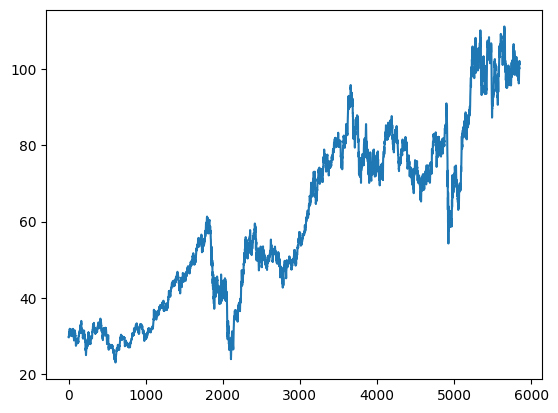

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-11-13,29.689144,29.907957,29.689144,29.718983,8.949275,1573674.0
1,2000-11-14,29.639414,29.699089,29.539951,29.669250,8.934299,1691576.0
2,2000-11-15,29.665274,29.798552,29.539951,29.679197,8.937295,2381115.0
3,2000-11-16,29.593660,29.768713,29.490221,29.639414,8.925314,985859.0
4,2000-11-17,29.619520,30.186449,29.559843,30.017365,9.039127,1459827.0
...,...,...,...,...,...,...,...
5846,2023-11-07,100.629997,100.639999,99.489998,100.010002,100.010002,1806507.0
5847,2023-11-08,100.580002,101.059998,100.209999,100.690002,100.690002,1432581.0
5848,2023-11-09,101.300003,103.000000,101.099998,102.110001,102.110001,3152761.0
5849,2023-11-10,101.750000,101.879997,101.010002,101.320000,101.320000,1407582.0


In [8]:
finance_data = pd.read_csv('./CBA.AX.csv') # Commonwealth Bank of Australia (CBA.AX) 2000/11/11 - 2023/11/11
describe_dataset(finance_data)

In [9]:
#converting dates to type datetime from object
def string_to_datetime(finance_date):
    year, month, day = finance_date.split('-')
    return datetime(year = int(year), month= int(month), day= int(day))

finance_data["Date"] = finance_data["Date"].apply(string_to_datetime)
#replacing index with Date so that RNN understands sequential nature of data
finance_data.index = finance_data.pop('Date')

## Adding technical indicators to dataset

In [10]:
# Adding indicators
finance_data['RSI']=ta.rsi(finance_data.Close, length=15)
finance_data['EMAF']=ta.ema(finance_data.Close, length=20)
finance_data['EMAM']=ta.ema(finance_data.Close, length=100)
finance_data['EMAS']=ta.ema(finance_data.Close, length=150)

## Preprocessing data

In [11]:
#Remove values where close values are higher than high values
filtered_finance_data = finance_data.loc[finance_data['High']>finance_data['Adj Close']]
print(f"{filtered_finance_data.shape=}\n{finance_data.shape=}\nThere are {finance_data.shape[0] - filtered_finance_data.shape[0]} corrupt data points.")

# Removing rows where Close are higher than High values
filtered_finance_data = filtered_finance_data.copy()
filtered_finance_data.loc[:, 'Target'] = filtered_finance_data['Adj Close'].pct_change()*100

filtered_finance_data.dropna(inplace=True) #Dropping NaN values
display(filtered_finance_data)

filtered_finance_data.shape=(5847, 10)
finance_data.shape=(5851, 10)
There are 4 corrupt data points.


,Open,High,Low,Close,Adj Close,Volume,RSI,EMAF,EMAM,EMAS,Target
Date,,,,,,,,,,,
2001-06-08,31.286489,31.867342,31.286489,31.807667,9.779713,2715781.0,69.557967,30.748417,30.085463,30.176205,1.362915
2001-06-11,31.807667,31.807667,31.807667,31.807667,9.779713,0.0,69.557967,30.849298,30.119566,30.197814,0.000000
2001-06-12,31.807667,32.682922,31.578905,32.623245,10.030473,8732322.0,75.679563,31.018245,30.169144,30.229939,2.564083
2001-06-13,32.225403,33.021091,32.225403,32.871899,10.106926,3605679.0,77.178645,31.194783,30.222664,30.264931,0.762207
2001-06-14,32.816200,33.120552,32.364647,32.433277,9.972063,2623594.0,69.125747,31.312735,30.266438,30.293651,-1.334362
...,...,...,...,...,...,...,...,...,...,...,...
2023-11-07,100.629997,100.639999,99.489998,100.010002,100.010002,1806507.0,53.710048,98.978905,100.243340,100.412350,-0.408281
2023-11-08,100.580002,101.059998,100.209999,100.690002,100.690002,1432581.0,56.631982,99.141866,100.252185,100.416027,0.679932
2023-11-09,101.300003,103.000000,101.099998,102.110001,102.110001,3152761.0,61.998870,99.424546,100.288973,100.438464,1.410268


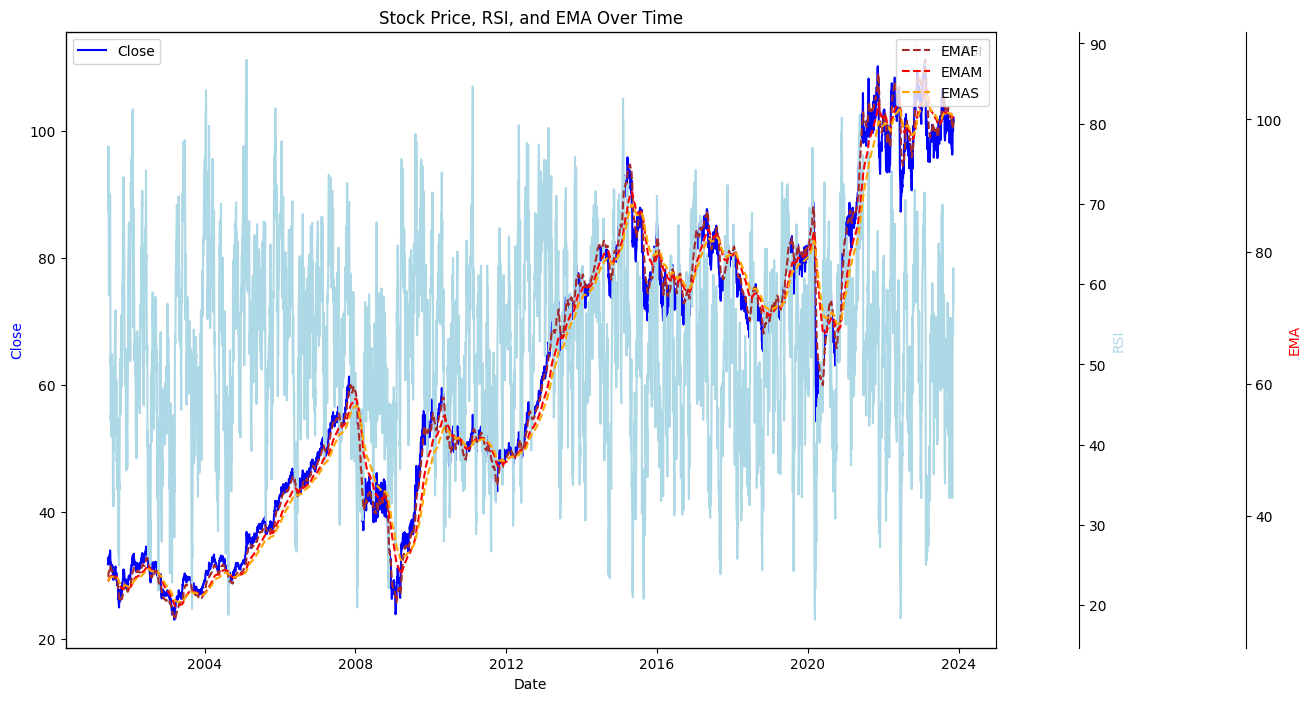

In [12]:
def plot_stock_data_with_indicators(df):
    fig, ax1 = plt.subplots(figsize=(12, 8))

    # Plotting Closing Prices
    ax1.plot(df.index, df['Close'], label='Close', color='blue')

    # Creating a secondary y-axis for RSI
    ax2 = ax1.twinx()
    ax2.plot(df.index, df['RSI'], label='RSI', color='lightblue')

    # Creating another secondary y-axis for EMA
    ax3 = ax1.twinx()
    ax3.plot(df.index, df['EMAF'], linestyle = 'dashed',label='EMAF', color='brown')
    ax3.plot(df.index, df['EMAM'], linestyle = 'dashed',label='EMAM', color='red')
    ax3.plot(df.index, df['EMAS'], linestyle = 'dashed',label='EMAS', color='orange')

    # Adjusting the positions of the secondary y-axes
    ax2.spines['right'].set_position(('outward', 60))
    ax3.spines['right'].set_position(('outward', 120))
    ax3.spines['right'].set_position(('outward', 180))


    # Adding legends
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    ax3.legend(loc='upper right')

    # Setting labels and title
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Close', color='blue')
    ax2.set_ylabel('RSI', color='lightblue')
    ax3.set_ylabel('EMA', color='red')
    plt.title('Stock Price, RSI, and EMA Over Time')

    # Show the plot
    plt.show()

plot_stock_data_with_indicators(filtered_finance_data)

<Axes: >

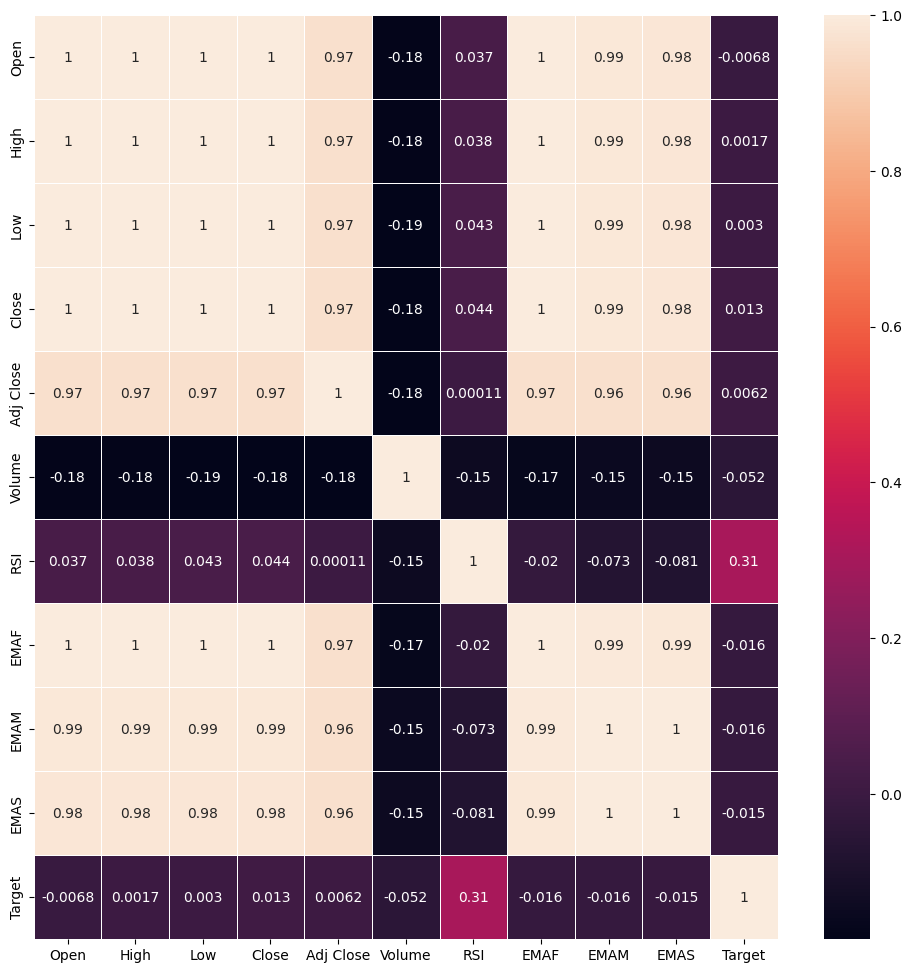

In [13]:
plt.figure(figsize=(12, 12))
sns.heatmap(filtered_finance_data.corr(),annot=True,linewidths=0.5)

In [14]:
features = filtered_finance_data.drop(columns=['Target']).values
targets  = filtered_finance_data['Target'].values
targets = targets.reshape(-1,1)
print(f"{features.shape=},\t{targets.shape=}")

features.shape=(5698, 10),	targets.shape=(5698, 1)


In [15]:
features = filtered_finance_data.drop(columns=['Target']).values
targets  = filtered_finance_data['Target'].values
targets = targets.reshape(-1,1)
print(f"{features.shape=},\t{targets.shape=}")

features.shape=(5698, 10),	targets.shape=(5698, 1)


In [16]:
from sklearn.preprocessing import MinMaxScaler

scaler_X = MinMaxScaler(feature_range=(0,1))
scaler_y = MinMaxScaler(feature_range=(0,1))

In [17]:
def create_sequences(Xsc,ysc, look_back):
    X,y =[],[]
    for i in range(Xsc.shape[0]-look_back):
        X.append(Xsc[i:i+look_back,:])

        y.append(ysc[i+look_back,:])

    return np.array(X),np.array(y)


# Define the look-back period (number of time steps to look back)
look_back = 30

# Create sequences for training
X,y = create_sequences(features,targets, look_back)
print(f"{X.shape=},\t\t{y.shape=}")

X.shape=(5668, 30, 10),		y.shape=(5668, 1)


In [18]:
def non_shuffling_train_test_split(X, y, test_size=0.2):
    i = int((1 - test_size) * X.shape[0]) + 1
    X_train, X_test = np.split(X, [i])
    y_train, y_test = np.split(y, [i])
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = non_shuffling_train_test_split(X, y, 0.2)
print(f"{X_train.shape=},\t{y_train.shape=}\n{X_test.shape=},\t{y_test.shape=}")

X_train.shape=(4535, 30, 10),	y_train.shape=(4535, 1)
X_test.shape=(1133, 30, 10),	y_test.shape=(1133, 1)


In [19]:
def reshape_for_scaling(data):
  num_samples, sequence_length, num_features = data.shape
  return data.reshape((num_samples * sequence_length, num_features))

def reshape_to_sequence(data):
  num_samples, num_features = data.shape
  return data.reshape((num_samples//look_back, look_back, num_features))

X_train_scaled_reshaped = scaler_X.fit_transform(reshape_for_scaling(X_train))
X_train_scaled = reshape_to_sequence(X_train_scaled_reshaped)
X_train = X_train_scaled

X_test_scaled_reshaped = scaler_X.transform(reshape_for_scaling(X_test))
X_test_scaled = reshape_to_sequence(X_test_scaled_reshaped)
X_test = X_test_scaled

y_train_scaled = scaler_y.fit_transform(y_train)
y_train = y_train_scaled

y_test_scaled = scaler_y.transform(y_test)
y_test = y_test_scaled

print(f"{X_train_scaled.shape=}\t{y_train_scaled.shape=}\n{X_test_scaled.shape=}\t{y_test_scaled.shape=}")

X_train_scaled.shape=(4535, 30, 10)	y_train_scaled.shape=(4535, 1)
X_test_scaled.shape=(1133, 30, 10)	y_test_scaled.shape=(1133, 1)


# Training models

In [20]:
def train(model,X_train,y_train,X_test,y_test,epochs,batch_size,shuffle,validation_split):
    print(model.summary())
    _model = model.fit(X_train,y_train,epochs=epochs,batch_size=batch_size,shuffle=shuffle,validation_split=validation_split)
    plot_loss(_model)
    predictions = model.predict(X_test)
    plot_residual(y_test,predictions)
    table = [[f'Training {model.loss} Loss',f'Validation {model.loss} Loss','Training RMSE'	,'Training MAE',	'Training MAPE','Validation RMSE'	,'Validation MAE',	'Validation MAPE'],
         [_model.history['loss'][-1],_model.history['val_loss'][-1] ,_model.history['root_mean_squared_error'][-1], _model.history['mean_absolute_error'][-1], _model.history['mean_absolute_percentage_error'][-1],_model.history['val_root_mean_squared_error'][-1] ,_model.history['val_mean_absolute_error'][-1] ,_model.history['val_mean_absolute_percentage_error'][-1] ]]
    print(tabulate(table,headers='firstrow'))
    return _model, predictions#, predicted_prices

def plot_loss(model):
    plt.plot(model.history['loss'])
    plt.plot(model.history['val_loss'])
    plt.title('Model Training & Validation Loss')
    plt.legend(['training loss','validation loss',])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

def reconstruct_original_shape(X_sequences, original_shape):
    reconstructed_X = []
    for sequence in X_sequences:
        for i in range(sequence.shape[0]):
            reconstructed_X.append(sequence[i, :])

    return np.array(reconstructed_X)[:original_shape[0], :]


def plot_residual(y_test,predictions):
    fig, axs = plt.subplots(1,2,figsize=(12,5))
    plt.figure(dpi=80, facecolor='w', edgecolor='k')
    residual = scaler_y.inverse_transform(y_test)-scaler_y.inverse_transform(predictions)
    _predicted = scaler_y.inverse_transform(predictions)
    axs[0].scatter(_predicted,residual, color='blue', marker='o',label='Fitted values')
    axs[0].axhline(y=0, color='red', linestyle='--', linewidth=2, label='Residuals')
    axs[0].set_title('Residual plot')
    axs[1].hist(residual, linewidth=1,bins=20, edgecolor='black')
    axs[1].set_title('Histogram plot of residual')
    axs[0].legend()
    axs[1].legend()
    plt.show()

# RNN

### Mean Absolute Error

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 10)                210       
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
Total params: 221 (884.00 Byte)
Trainable params: 221 (884.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/25
128/128 [==============================] - 3s 10ms/step - loss: 0.1305 - root_mean_squared_error: 0.1880 - mean_absolute_error: 0.1305 - mean_absolute_percentage_error: 32716.9258 - val_loss: 0.0928 - val_root_mean_squared_error: 0.1090 - val_mean_absolute_error: 0.0928 - val_mean_absolute_percentage_error: 21.1930
Epoch 2/25
128/128 [==============================] - 1s 8ms/step - loss: 0.0616 

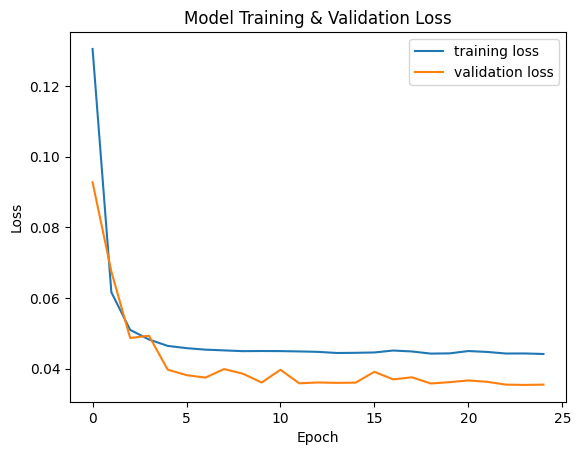

36/36 [==============================] - 0s 4ms/step


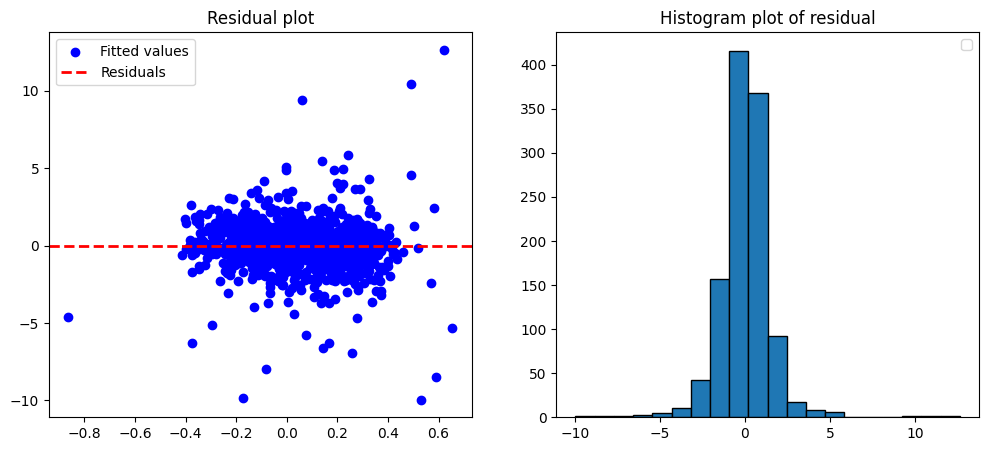

<Figure size 512x384 with 0 Axes>

  Training mean_absolute_error Loss    Validation mean_absolute_error Loss    Training RMSE    Training MAE    Training MAPE    Validation RMSE    Validation MAE    Validation MAPE
-----------------------------------  -------------------------------------  ---------------  --------------  ---------------  -----------------  ----------------  -----------------
                          0.0441719                              0.0355064        0.0637097       0.0441719           101436          0.0477037         0.0355064            8.63259


In [21]:
model_simple_rnn1 = Sequential()
model_simple_rnn1.add(SimpleRNN(10, activation='tanh',input_shape=(look_back, features.shape[1])))
model_simple_rnn1.add(Dense(1,activation='tanh'))

# Compile the model
model_simple_rnn1.compile(optimizer='adam', loss='mean_absolute_error', metrics=[RootMeanSquaredError(),MeanAbsoluteError(),MeanAbsolutePercentageError()])


# Train the model
# model_simple_rnn.fit(X_train, y_train, epochs=10, batch_size=32, shuffle=True, validation_split = 0.1)

rnn1_stats, rnn1_predictions= train(model=model_simple_rnn1,
                                    X_train=X_train,
                                    y_train=y_train,
                                    X_test=X_test,
                                    y_test=y_test,
                                    epochs=25,
                                    batch_size=32,
                                    shuffle=True,
                                    validation_split = 0.1)


### Mean Absolute Percentage Error

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 50)                3050      
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 3101 (12.11 KB)
Trainable params: 3101 (12.11 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/25
128/128 [==============================] - 2s 10ms/step - loss: 105521.3516 - root_mean_squared_error: 0.6240 - mean_absolute_error: 0.4556 - mean_absolute_percentage_error: 105521.3516 - val_loss: 184.5747 - val_root_mean_squared_error: 0.7763 - val_mean_absolute_error: 0.7744 - val_mean_absolute_percentage_error: 184.5747
Epoch 2/25
128/128 [==============================] - 1s 8ms/step - loss: 

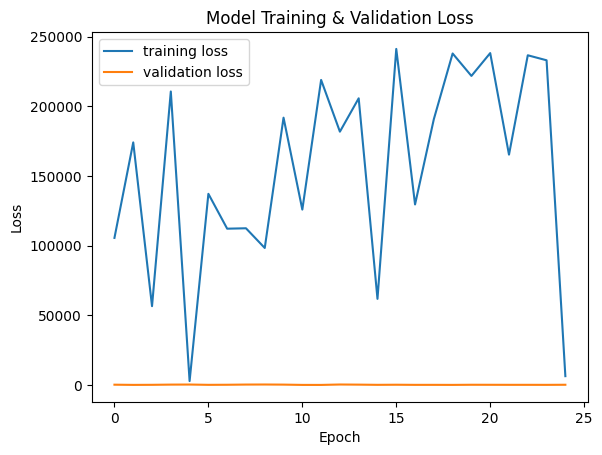

36/36 [==============================] - 0s 3ms/step


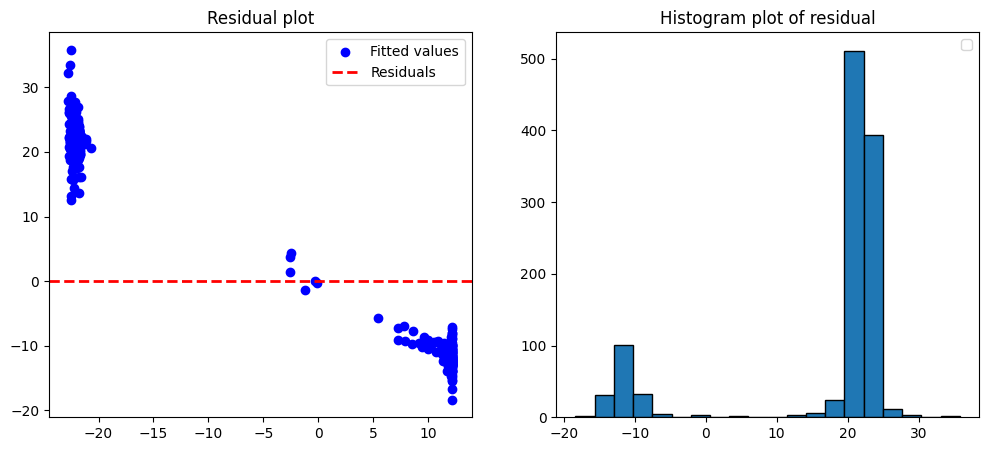

<Figure size 512x384 with 0 Axes>

  Training mean_absolute_percentage_error Loss    Validation mean_absolute_percentage_error Loss    Training RMSE    Training MAE    Training MAPE    Validation RMSE    Validation MAE    Validation MAPE
----------------------------------------------  ------------------------------------------------  ---------------  --------------  ---------------  -----------------  ----------------  -----------------
                                       6312.54                                           133.458         0.554777        0.510264          6312.54           0.556907          0.551143            133.458


In [22]:
model_simple_rnn2 = Sequential()
model_simple_rnn2.add(SimpleRNN(50, activation='tanh', input_shape=(look_back, features.shape[1])))
model_simple_rnn2.add(Dense(1, activation='tanh'))

# Compile the model
model_simple_rnn2.compile(optimizer='adam', loss='mean_absolute_percentage_error', metrics=[RootMeanSquaredError(),MeanAbsoluteError(),MeanAbsolutePercentageError()])

# Train the model
# model_simple_rnn.fit(X_train, y_train, epochs=10, batch_size=32, shuffle=True, validation_split = 0.1)

rnn2_stats, rnn2_predictions= train(model=model_simple_rnn2,
                                    X_train=X_train,
                                    y_train=y_train,
                                    X_test=X_test,
                                    y_test=y_test,
                                    epochs=25,
                                    batch_size=32,
                                    shuffle=True,
                                    validation_split = 0.1)

### Huber

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 50)                3050      
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 3101 (12.11 KB)
Trainable params: 3101 (12.11 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/25
128/128 [==============================] - 2s 10ms/step - loss: 0.0043 - root_mean_squared_error: 0.0932 - mean_absolute_error: 0.0619 - mean_absolute_percentage_error: 127694.5859 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0496 - val_mean_absolute_error: 0.0368 - val_mean_absolute_percentage_error: 9.1903
Epoch 2/25
128/128 [==============================] - 1s 8ms/step - loss: 0.0022 - 

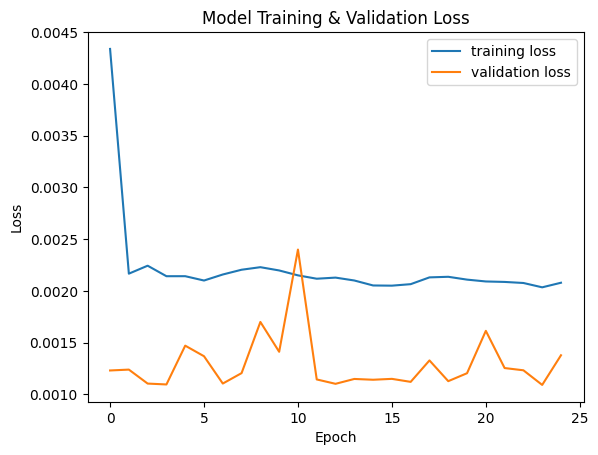

36/36 [==============================] - 0s 3ms/step


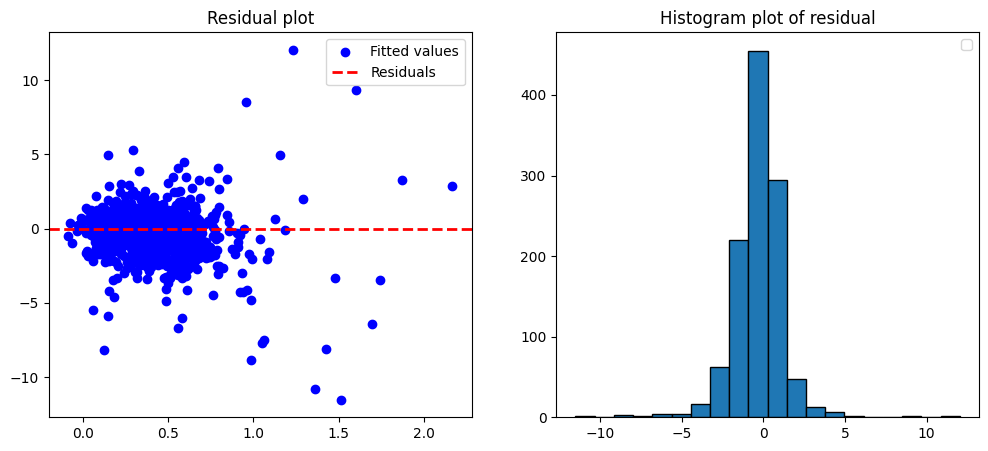

<Figure size 512x384 with 0 Axes>

  Training <keras.src.losses.Huber object at 0x780e7da1b8e0> Loss    Validation <keras.src.losses.Huber object at 0x780e7da1b8e0> Loss    Training RMSE    Training MAE    Training MAPE    Validation RMSE    Validation MAE    Validation MAPE
-----------------------------------------------------------------  -------------------------------------------------------------------  ---------------  --------------  ---------------  -----------------  ----------------  -----------------
                                                        0.0020787                                                           0.00137764        0.0644779       0.0455945           103124          0.0524908         0.0405446            10.2199


In [23]:
model_simple_rnn3 = Sequential()
model_simple_rnn3.add(SimpleRNN(50, activation='tanh',input_shape=(look_back, features.shape[1])))
model_simple_rnn3.add(Dense(1, activation='tanh'))

# Compile the model
model_simple_rnn3.compile(optimizer='adam', loss=Huber(delta=1.0), metrics=[RootMeanSquaredError(),MeanAbsoluteError(),MeanAbsolutePercentageError()])

# Train the model
rnn3_stats, rnn3_predictions= train(model=model_simple_rnn3,
                                    X_train=X_train,
                                    y_train=y_train,
                                    X_test=X_test,
                                    y_test=y_test,
                                    epochs=25,
                                    batch_size=32,
                                    shuffle=True,
                                    validation_split = 0.1)

# RNN with Dropout

### Mean Absolute Error

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_3 (SimpleRNN)    (None, 10)                210       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 221 (884.00 Byte)
Trainable params: 221 (884.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/25
128/128 [==============================] - 2s 9ms/step - loss: 0.1966 - root_mean_squared_error: 0.2574 - mean_absolute_error: 0.1966 - mean_absolute_percentage_error: 5107.0264 - val_loss: 0.0550 - val_root_mean_squared_error: 0.0722 - val_mean_absolute_error: 0.

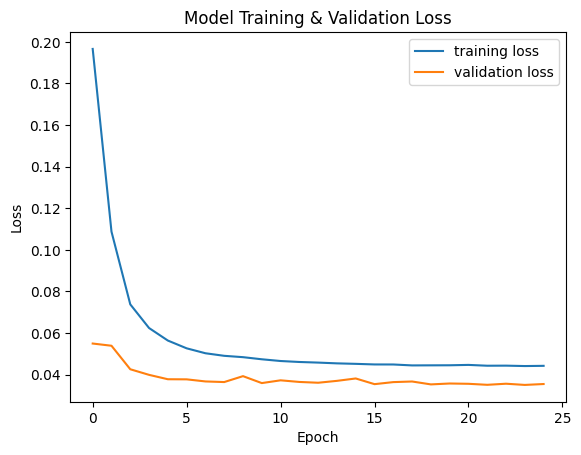

36/36 [==============================] - 0s 3ms/step


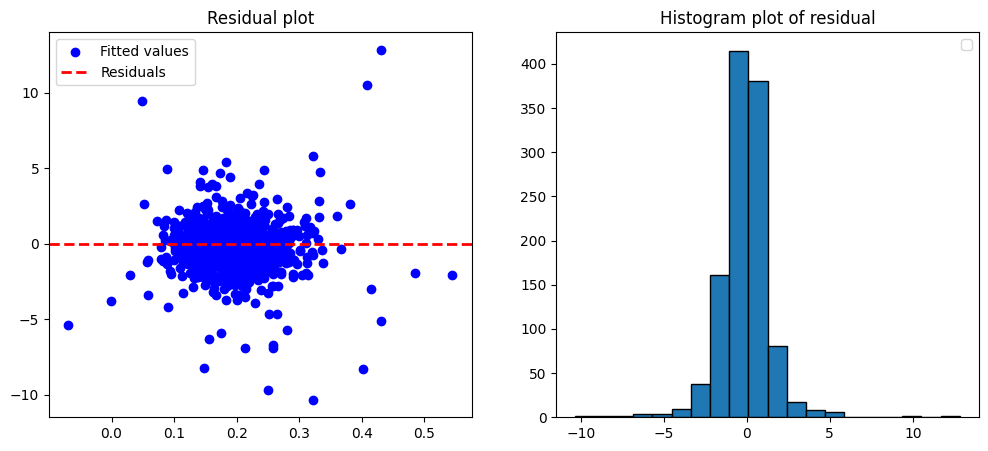

<Figure size 512x384 with 0 Axes>

  Training mean_absolute_error Loss    Validation mean_absolute_error Loss    Training RMSE    Training MAE    Training MAPE    Validation RMSE    Validation MAE    Validation MAPE
-----------------------------------  -------------------------------------  ---------------  --------------  ---------------  -----------------  ----------------  -----------------
                          0.0442345                               0.035486        0.0636637       0.0442345           103821          0.0475372          0.035486            8.69023


In [24]:
model_simple_rnn_with_dropout1 = Sequential()
model_simple_rnn_with_dropout1.add(SimpleRNN(10, activation='tanh', input_shape=(look_back, features.shape[1])))
model_simple_rnn_with_dropout1.add(Dropout(0.2))
model_simple_rnn_with_dropout1.add(Dense(1, activation='tanh'))


model_simple_rnn_with_dropout1.compile(optimizer='adam', loss='mean_absolute_error', metrics=[RootMeanSquaredError(), MeanAbsoluteError(), MeanAbsolutePercentageError()])

# Train the model
rnn_with_dropout_stats1, rnn_with_dropout_predictions1 = train(model=model_simple_rnn_with_dropout1,
                                                            X_train=X_train,
                                                            y_train=y_train,
                                                            X_test=X_test,
                                                            y_test=y_test,
                                                            epochs=25,
                                                            batch_size=32,
                                                            shuffle=True,
                                                            validation_split=0.1)

### Mean Absolute Percentage Error

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_4 (SimpleRNN)    (None, 10)                210       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 11        
                                                                 
Total params: 221 (884.00 Byte)
Trainable params: 221 (884.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/25
128/128 [==============================] - 2s 9ms/step - loss: 13758.5283 - root_mean_squared_error: 0.3117 - mean_absolute_error: 0.2354 - mean_absolute_percentage_error: 13758.5283 - val_loss: 20.7939 - val_root_mean_squared_error: 0.1187 - val_mean_absolute_err

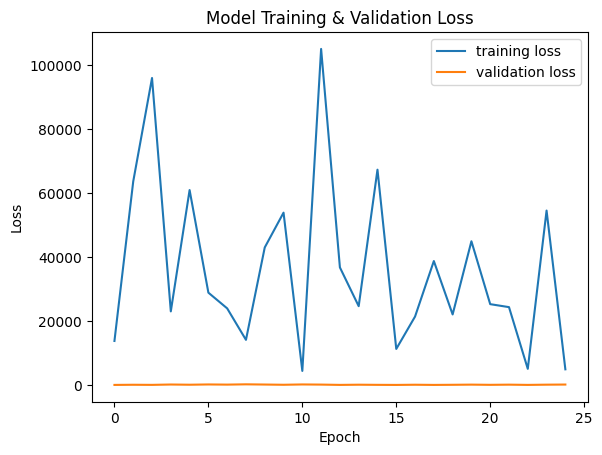

36/36 [==============================] - 0s 3ms/step


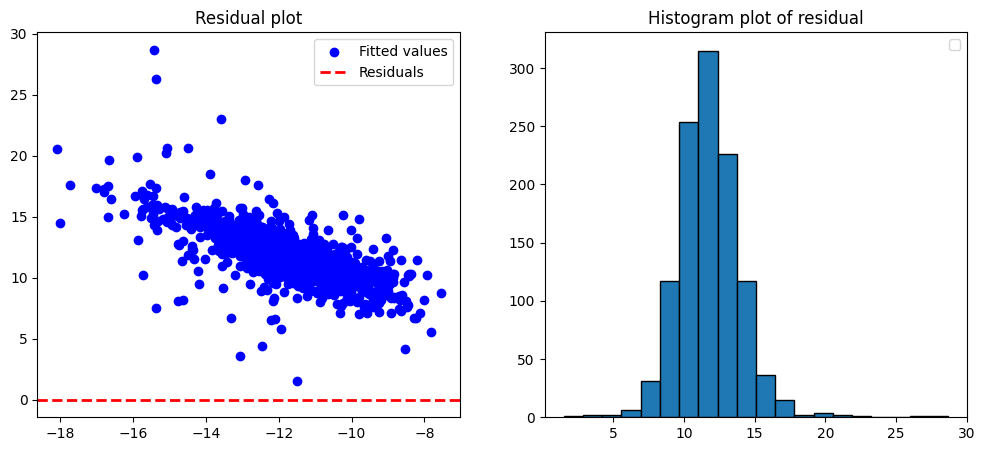

<Figure size 512x384 with 0 Axes>

  Training mean_absolute_percentage_error Loss    Validation mean_absolute_percentage_error Loss    Training RMSE    Training MAE    Training MAPE    Validation RMSE    Validation MAE    Validation MAPE
----------------------------------------------  ------------------------------------------------  ---------------  --------------  ---------------  -----------------  ----------------  -----------------
                                       4894.23                                           135.251         0.434246        0.372689          4894.23           0.577343          0.569169            135.251


In [25]:
model_simple_rnn_with_dropout2 = Sequential()
model_simple_rnn_with_dropout2.add(SimpleRNN(10, activation='tanh', input_shape=(look_back, features.shape[1])))
model_simple_rnn_with_dropout2.add(Dropout(0.2))
model_simple_rnn_with_dropout2.add(Dense(1, activation='tanh'))


model_simple_rnn_with_dropout2.compile(optimizer='adam', loss='mean_absolute_percentage_error', metrics=[RootMeanSquaredError(), MeanAbsoluteError(), MeanAbsolutePercentageError()])

# Train the model
rnn_with_dropout_stats2, rnn_with_dropout_predictions2 = train(model=model_simple_rnn_with_dropout2,
                                                            X_train=X_train,
                                                            y_train=y_train,
                                                            X_test=X_test,
                                                            y_test=y_test,
                                                            epochs=25,
                                                            batch_size=32,
                                                            shuffle=True,
                                                            validation_split=0.1)

### Huber

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_5 (SimpleRNN)    (None, 10)                210       
                                                                 
 dropout_2 (Dropout)         (None, 10)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                                 
Total params: 221 (884.00 Byte)
Trainable params: 221 (884.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/25
128/128 [==============================] - 2s 9ms/step - loss: 0.0432 - root_mean_squared_error: 0.2944 - mean_absolute_error: 0.2192 - mean_absolute_percentage_error: 163387.4375 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0601 - val_mean_absolute_error: 

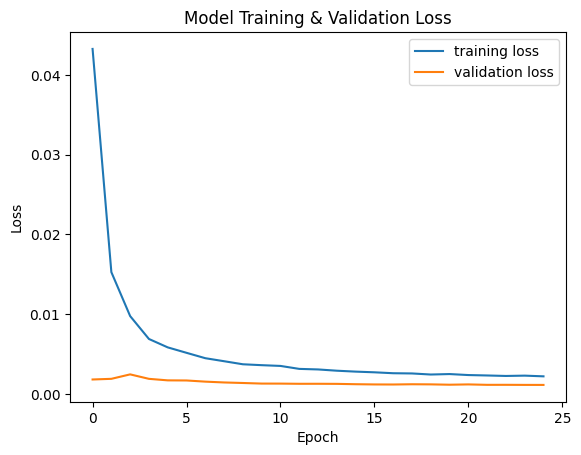

36/36 [==============================] - 0s 3ms/step


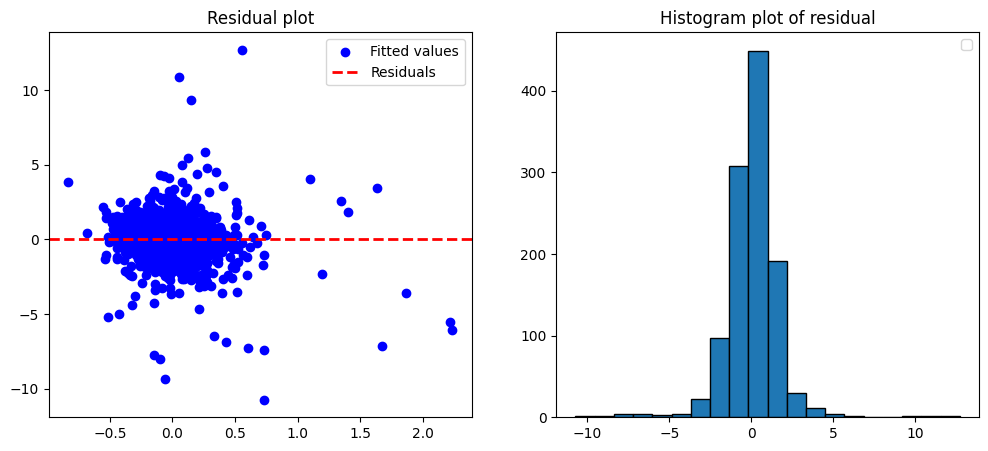

<Figure size 512x384 with 0 Axes>

  Training <keras.src.losses.Huber object at 0x780e7c09bdc0> Loss    Validation <keras.src.losses.Huber object at 0x780e7c09bdc0> Loss    Training RMSE    Training MAE    Training MAPE    Validation RMSE    Validation MAE    Validation MAPE
-----------------------------------------------------------------  -------------------------------------------------------------------  ---------------  --------------  ---------------  -----------------  ----------------  -----------------
                                                       0.00220018                                                           0.00112407        0.0663353       0.0469829           106391          0.0474145         0.0354928            8.63748


In [26]:
model_simple_rnn_with_dropout3 = Sequential()
model_simple_rnn_with_dropout3.add(SimpleRNN(10, activation='tanh', input_shape=(look_back, features.shape[1])))
model_simple_rnn_with_dropout3.add(Dropout(0.2))
model_simple_rnn_with_dropout3.add(Dense(1, activation='tanh'))


model_simple_rnn_with_dropout3.compile(optimizer='adam', loss=Huber(delta=1.0), metrics=[RootMeanSquaredError(), MeanAbsoluteError(), MeanAbsolutePercentageError()])

# Train the model
rnn_with_dropout_stats3, rnn_with_dropout_predictions3 = train(model=model_simple_rnn_with_dropout3,
                                                            X_train=X_train,
                                                            y_train=y_train,
                                                            X_test=X_test,
                                                            y_test=y_test,
                                                            epochs=25,
                                                            batch_size=32,
                                                            shuffle=True,
                                                            validation_split=0.1)

# LTSM

### Mean Absolute Error

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                12200     
                                                                 
 dense_6 (Dense)             (None, 1)                 51        
                                                                 
Total params: 12251 (47.86 KB)
Trainable params: 12251 (47.86 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/25
128/128 [==============================] - 5s 21ms/step - loss: 0.0590 - root_mean_squared_error: 0.0827 - mean_absolute_error: 0.0590 - mean_absolute_percentage_error: 84322.2344 - val_loss: 0.0358 - val_root_mean_squared_error: 0.0481 - val_mean_absolute_error: 0.0358 - val_mean_absolute_percentage_error: 8.5611
Epoch 2/25
128/128 [==============================] - 3s 21ms/step - loss: 0.0458 

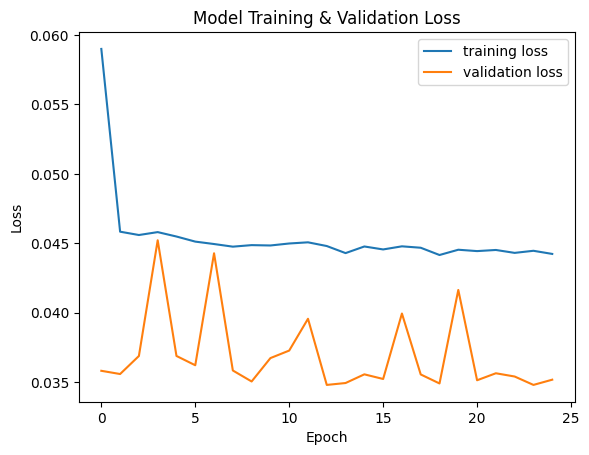

36/36 [==============================] - 1s 6ms/step


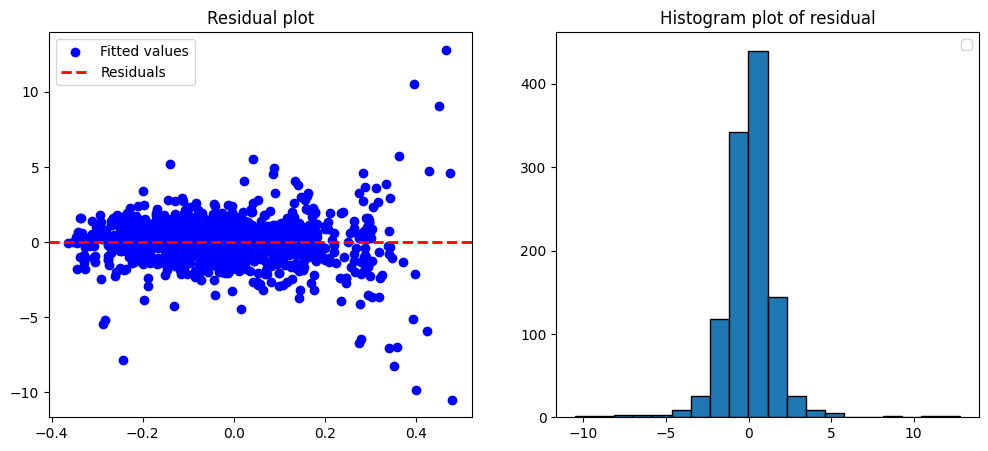

<Figure size 512x384 with 0 Axes>

  Training mean_absolute_error Loss    Validation mean_absolute_error Loss    Training RMSE    Training MAE    Training MAPE    Validation RMSE    Validation MAE    Validation MAPE
-----------------------------------  -------------------------------------  ---------------  --------------  ---------------  -----------------  ----------------  -----------------
                          0.0442332                              0.0351825        0.0637488       0.0442332           101875          0.0473504         0.0351825              8.614


In [27]:
model_lstm1 = Sequential()
model_lstm1.add(LSTM(50, activation='tanh',input_shape=(look_back, features.shape[1])))
model_lstm1.add(Dense(1,activation='tanh'))

# Compile the model
model_lstm1.compile(optimizer='adam', loss='mean_absolute_error', metrics=[RootMeanSquaredError(),MeanAbsoluteError(),MeanAbsolutePercentageError()])

# Train the model

lstm1_stats, lstm1_predictions= train(model=model_lstm1,
                                    X_train=X_train,
                                    y_train=y_train,
                                    X_test=X_test,
                                    y_test=y_test,
                                    epochs=25,
                                    batch_size=32,
                                    shuffle=True,
                                    validation_split = 0.1)

### Mean Absolute Percentage Error

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 50)                12200     
                                                                 
 dense_7 (Dense)             (None, 1)                 51        
                                                                 
Total params: 12251 (47.86 KB)
Trainable params: 12251 (47.86 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/25
128/128 [==============================] - 6s 31ms/step - loss: 100643.4688 - root_mean_squared_error: 0.1102 - mean_absolute_error: 0.0744 - mean_absolute_percentage_error: 100643.4688 - val_loss: 77.8223 - val_root_mean_squared_error: 0.3329 - val_mean_absolute_error: 0.3295 - val_mean_absolute_percentage_error: 77.8223
Epoch 2/25
128/128 [==============================] - 2s 18ms/step - loss:

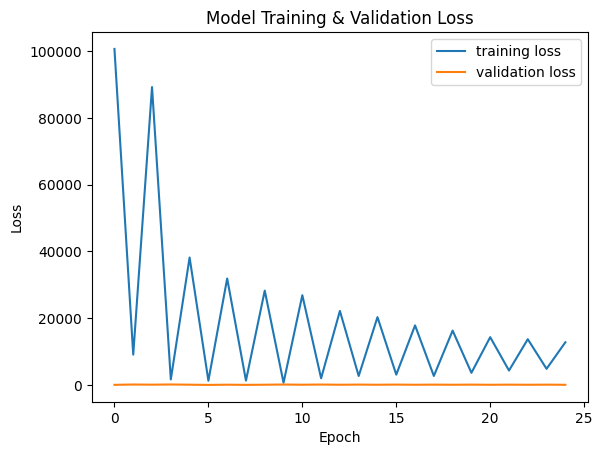

36/36 [==============================] - 1s 8ms/step


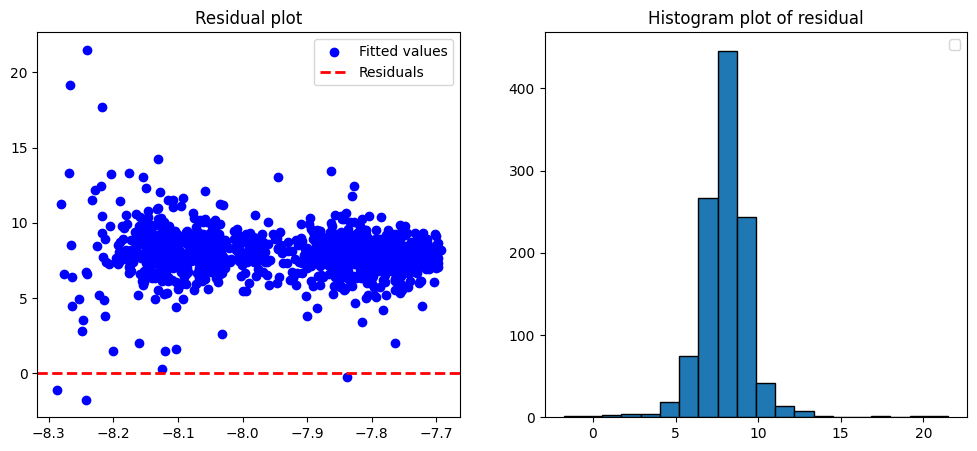

<Figure size 512x384 with 0 Axes>

  Training mean_absolute_percentage_error Loss    Validation mean_absolute_percentage_error Loss    Training RMSE    Training MAE    Training MAPE    Validation RMSE    Validation MAE    Validation MAPE
----------------------------------------------  ------------------------------------------------  ---------------  --------------  ---------------  -----------------  ----------------  -----------------
                                       12820.2                                           89.5884         0.463526        0.455297          12820.2           0.381518          0.378575            89.5884


In [28]:
model_lstm2 = Sequential()
model_lstm2.add(LSTM(50, activation='tanh', input_shape=(look_back, features.shape[1])))
model_lstm2.add(Dense(1, activation='tanh'))

# Compile the model
model_lstm2.compile(optimizer='adam', loss='mean_absolute_percentage_error', metrics=[RootMeanSquaredError(),MeanAbsoluteError(),MeanAbsolutePercentageError()])

# Train the model
lstm2_stats, lstm2_predictions= train(model=model_lstm2,
                                    X_train=X_train,
                                    y_train=y_train,
                                    X_test=X_test,
                                    y_test=y_test,
                                    epochs=25,
                                    batch_size=32,
                                    shuffle=True,
                                    validation_split = 0.1)

### Huber

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 50)                12200     
                                                                 
 dense_8 (Dense)             (None, 1)                 51        
                                                                 
Total params: 12251 (47.86 KB)
Trainable params: 12251 (47.86 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/25
128/128 [==============================] - 6s 21ms/step - loss: 0.0041 - root_mean_squared_error: 0.0901 - mean_absolute_error: 0.0628 - mean_absolute_percentage_error: 99848.6484 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0478 - val_mean_absolute_error: 0.0357 - val_mean_absolute_percentage_error: 8.7360
Epoch 2/25
128/128 [==============================] - 2s 17ms/step - loss: 0.0021 

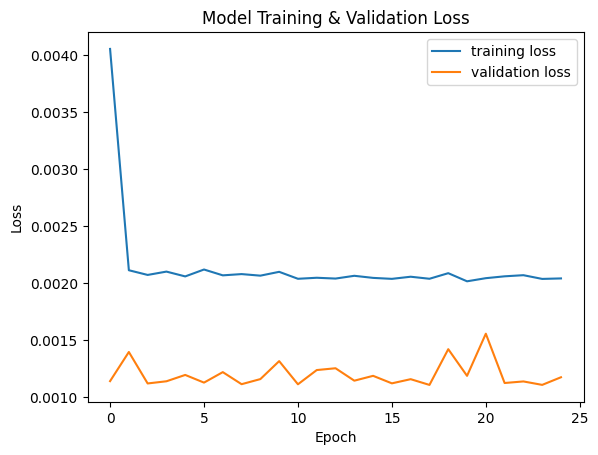

36/36 [==============================] - 1s 8ms/step


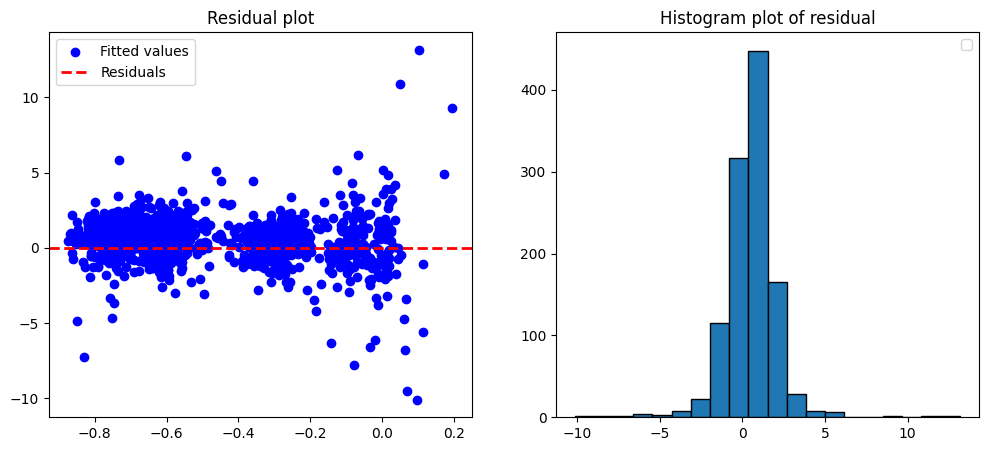

<Figure size 512x384 with 0 Axes>

  Training <keras.src.losses.Huber object at 0x780e682c8d90> Loss    Validation <keras.src.losses.Huber object at 0x780e682c8d90> Loss    Training RMSE    Training MAE    Training MAPE    Validation RMSE    Validation MAE    Validation MAPE
-----------------------------------------------------------------  -------------------------------------------------------------------  ---------------  --------------  ---------------  -----------------  ----------------  -----------------
                                                        0.0020436                                                           0.00117721        0.0639312       0.0446868           105531          0.0485223         0.0361703             8.5232


In [29]:
model_lstm3 = Sequential()
model_lstm3.add(LSTM(50, activation='tanh',input_shape=(look_back, features.shape[1])))
model_lstm3.add(Dense(1, activation='tanh'))

# Compile the model
model_lstm3.compile(optimizer='adam', loss=Huber(delta=1.0), metrics=[RootMeanSquaredError(),MeanAbsoluteError(),MeanAbsolutePercentageError()])

# Train the model
lstm3_stats, lstm3_predictions= train(model=model_lstm3,
                                    X_train=X_train,
                                    y_train=y_train,
                                    X_test=X_test,
                                    y_test=y_test,
                                    epochs=25,
                                    batch_size=32,
                                    shuffle=True,
                                    validation_split = 0.1)

# LTSM with dropout

### Mean Absolute Error

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 50)                12200     
                                                                 
 dropout_3 (Dropout)         (None, 50)                0         
                                                                 
 dense_9 (Dense)             (None, 1)                 51        
                                                                 
Total params: 12251 (47.86 KB)
Trainable params: 12251 (47.86 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/25
128/128 [==============================] - 6s 21ms/step - loss: 0.0900 - root_mean_squared_error: 0.1316 - mean_absolute_error: 0.0900 - mean_absolute_percentage_error: 90778.4375 - val_loss: 0.0400 - val_root_mean_squared_error: 0.0521 - val_mean_absolute_error: 0.

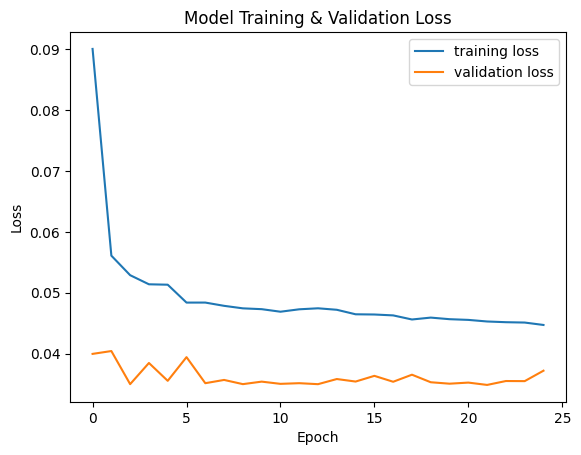

36/36 [==============================] - 1s 5ms/step


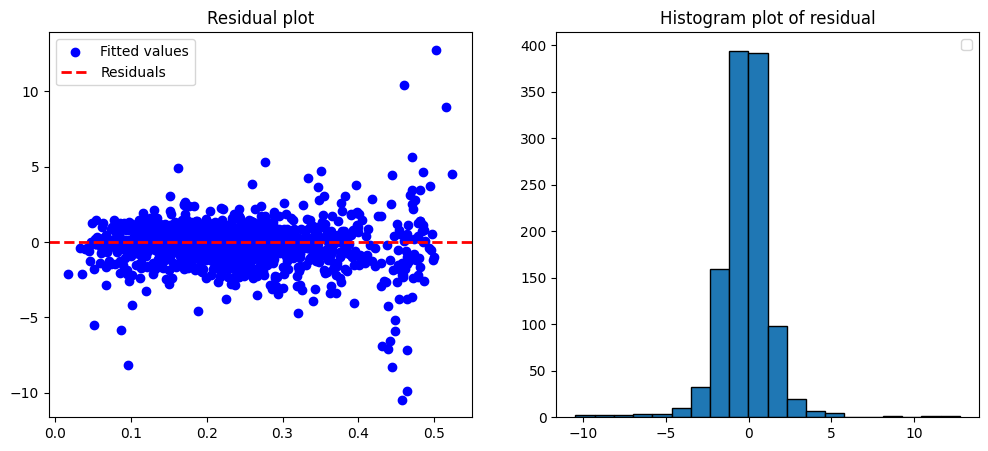

<Figure size 512x384 with 0 Axes>

  Training mean_absolute_error Loss    Validation mean_absolute_error Loss    Training RMSE    Training MAE    Training MAPE    Validation RMSE    Validation MAE    Validation MAPE
-----------------------------------  -------------------------------------  ---------------  --------------  ---------------  -----------------  ----------------  -----------------
                           0.044708                              0.0371989        0.0639365        0.044708           109737          0.0491943         0.0371989            9.26816


In [30]:
# Create the model
model_lstm_with_dropout1 = Sequential()
model_lstm_with_dropout1.add(LSTM(50, activation='tanh', input_shape=(look_back, features.shape[1])))
model_lstm_with_dropout1.add(Dropout(0.2))
model_lstm_with_dropout1.add(Dense(1, activation='tanh'))

# Compile the model
model_lstm_with_dropout1.compile(optimizer='adam',loss='mean_absolute_error', metrics=[RootMeanSquaredError(), MeanAbsoluteError(), MeanAbsolutePercentageError()])

# Train the model
lstm_with_dropout_stats1, lstm_with_dropout_predictions1 = train(model=model_lstm_with_dropout1,
                                                              X_train=X_train,
                                                              y_train=y_train,
                                                              X_test=X_test,
                                                              y_test=y_test,
                                                              epochs=25,
                                                              batch_size=32,
                                                              shuffle=True,
                                                              validation_split=0.1)


### Mean Absolute Percentage Error

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 50)                12200     
                                                                 
 dropout_4 (Dropout)         (None, 50)                0         
                                                                 
 dense_10 (Dense)            (None, 1)                 51        
                                                                 
Total params: 12251 (47.86 KB)
Trainable params: 12251 (47.86 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/25
128/128 [==============================] - 5s 20ms/step - loss: 89025.7891 - root_mean_squared_error: 0.1103 - mean_absolute_error: 0.0827 - mean_absolute_percentage_error: 89025.7891 - val_loss: 22.9005 - val_root_mean_squared_error: 0.1103 - val_mean_absolute_err

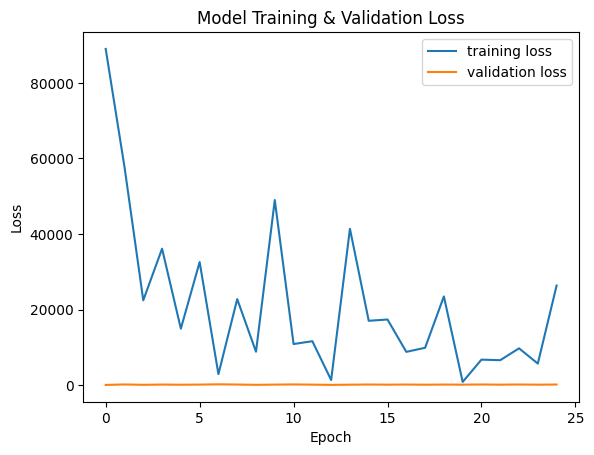

36/36 [==============================] - 1s 5ms/step


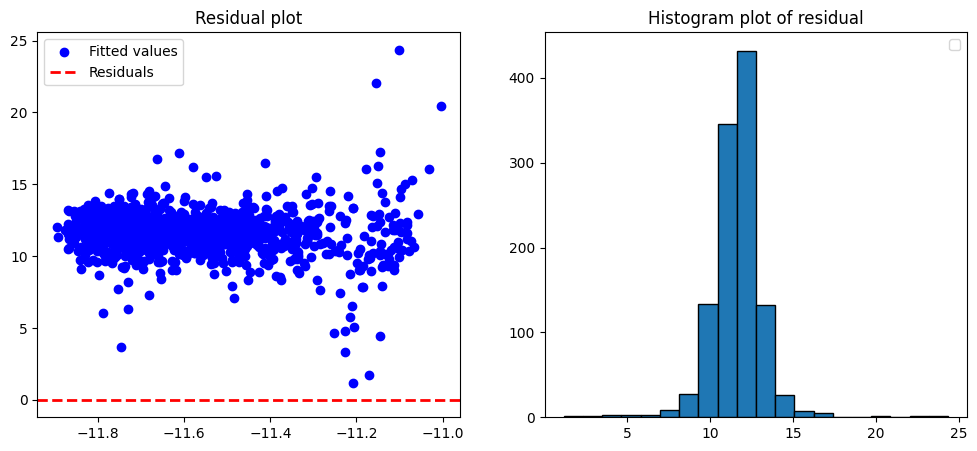

<Figure size 512x384 with 0 Axes>

  Training mean_absolute_percentage_error Loss    Validation mean_absolute_percentage_error Loss    Training RMSE    Training MAE    Training MAPE    Validation RMSE    Validation MAE    Validation MAPE
----------------------------------------------  ------------------------------------------------  ---------------  --------------  ---------------  -----------------  ----------------  -----------------
                                       26343.7                                           125.206         0.371476        0.354062          26343.7           0.529058          0.526961            125.206


In [31]:
# Create the model
model_lstm_with_dropout2 = Sequential()
model_lstm_with_dropout2.add(LSTM(50, activation='tanh', input_shape=(look_back, features.shape[1])))
model_lstm_with_dropout2.add(Dropout(0.2))
model_lstm_with_dropout2.add(Dense(1, activation='tanh'))

# Compile the model
model_lstm_with_dropout2.compile(optimizer='adam',loss='mean_absolute_percentage_error', metrics=[RootMeanSquaredError(), MeanAbsoluteError(), MeanAbsolutePercentageError()])

# Train the model
lstm_with_dropout_stats2, lstm_with_dropout_predictions2 = train(model=model_lstm_with_dropout2,
                                                              X_train=X_train,
                                                              y_train=y_train,
                                                              X_test=X_test,
                                                              y_test=y_test,
                                                              epochs=25,
                                                              batch_size=32,
                                                              shuffle=True,
                                                              validation_split=0.1)


### Huber

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 50)                12200     
                                                                 
 dropout_5 (Dropout)         (None, 50)                0         
                                                                 
 dense_11 (Dense)            (None, 1)                 51        
                                                                 
Total params: 12251 (47.86 KB)
Trainable params: 12251 (47.86 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/25
128/128 [==============================] - 5s 24ms/step - loss: 0.0150 - root_mean_squared_error: 0.1730 - mean_absolute_error: 0.1181 - mean_absolute_percentage_error: 87765.3828 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0508 - val_mean_absolute_error: 0

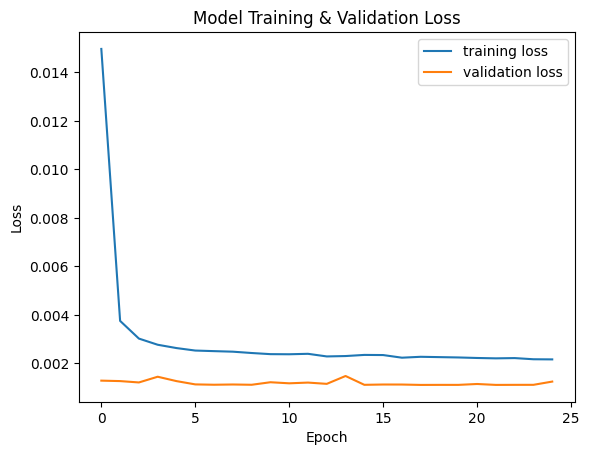

36/36 [==============================] - 1s 5ms/step


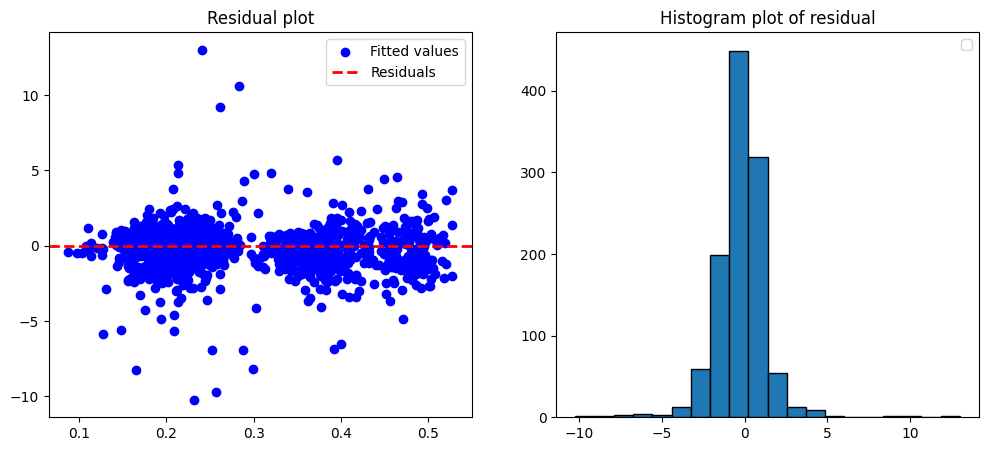

<Figure size 512x384 with 0 Axes>

  Training <keras.src.losses.Huber object at 0x780e66cae560> Loss    Validation <keras.src.losses.Huber object at 0x780e66cae560> Loss    Training RMSE    Training MAE    Training MAPE    Validation RMSE    Validation MAE    Validation MAPE
-----------------------------------------------------------------  -------------------------------------------------------------------  ---------------  --------------  ---------------  -----------------  ----------------  -----------------
                                                       0.00216438                                                           0.00124942        0.0657933       0.0465402           109933          0.0499884          0.037988            9.50174


In [32]:
# Create the model
model_lstm_with_dropout3 = Sequential()
model_lstm_with_dropout3.add(LSTM(50, activation='tanh', input_shape=(look_back, features.shape[1])))
model_lstm_with_dropout3.add(Dropout(0.2))
model_lstm_with_dropout3.add(Dense(1, activation='tanh'))

# Compile the model
model_lstm_with_dropout3.compile(optimizer='adam',loss=Huber(delta=1.0), metrics=[RootMeanSquaredError(), MeanAbsoluteError(), MeanAbsolutePercentageError()])

# Train the model
lstm_with_dropout_stats3, lstm_with_dropout_predictions3 = train(model=model_lstm_with_dropout3,
                                                              X_train=X_train,
                                                              y_train=y_train,
                                                              X_test=X_test,
                                                              y_test=y_test,
                                                              epochs=25,
                                                              batch_size=32,
                                                              shuffle=True,
                                                              validation_split=0.1)


# GRU

### Mean Absolute Error

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 50)                9300      
                                                                 
 dense_12 (Dense)            (None, 1)                 51        
                                                                 
Total params: 9351 (36.53 KB)
Trainable params: 9351 (36.53 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/25
128/128 [==============================] - 6s 26ms/step - loss: 0.0587 - root_mean_squared_error: 0.0817 - mean_absolute_error: 0.0587 - mean_absolute_percentage_error: 62224.2617 - val_loss: 0.0357 - val_root_mean_squared_error: 0.0479 - val_mean_absolute_error: 0.0357 - val_mean_absolute_percentage_error: 8.5260
Epoch 2/25
128/128 [==============================] - 2s 17ms/step - loss: 0.0463 -

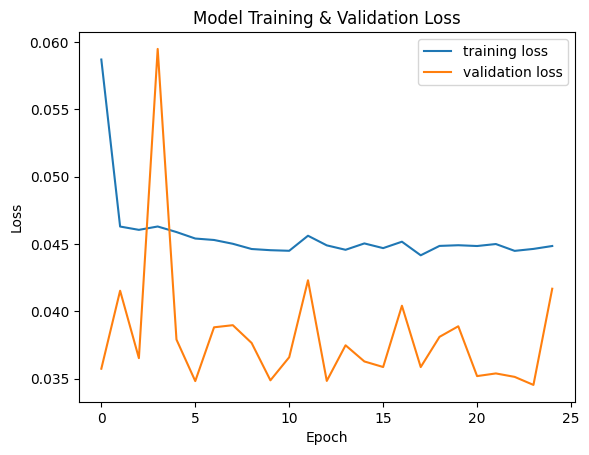

36/36 [==============================] - 1s 5ms/step


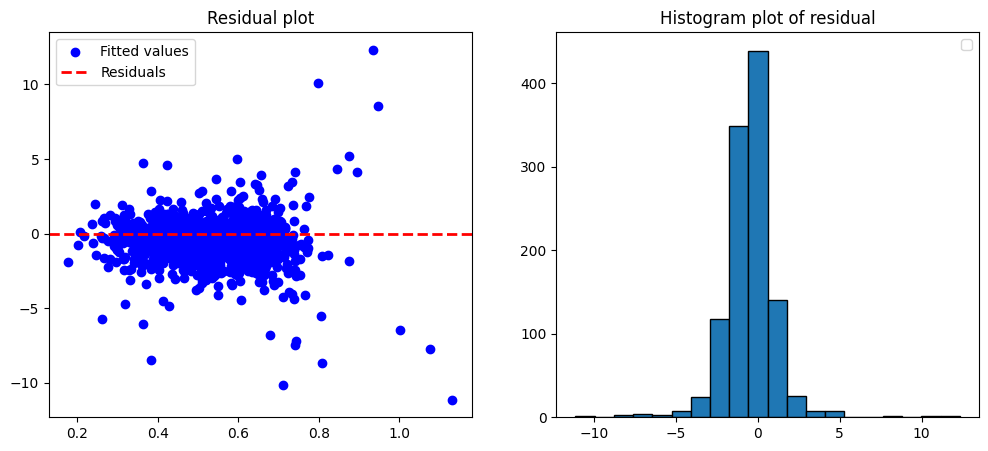

<Figure size 512x384 with 0 Axes>

  Training mean_absolute_error Loss    Validation mean_absolute_error Loss    Training RMSE    Training MAE    Training MAPE    Validation RMSE    Validation MAE    Validation MAPE
-----------------------------------  -------------------------------------  ---------------  --------------  ---------------  -----------------  ----------------  -----------------
                          0.0448546                              0.0416838        0.0642018       0.0448546           101117          0.0537435         0.0416838            10.5437


In [33]:
model_gru1 = Sequential()
model_gru1.add(GRU(50, activation='tanh',input_shape=(look_back, features.shape[1])))
model_gru1.add(Dense(1, activation='tanh'))

# Compile the model
model_gru1.compile(optimizer='adam', loss='mean_absolute_error', metrics=[RootMeanSquaredError(),MeanAbsoluteError(),MeanAbsolutePercentageError()])

# Train the model
gru1_stats, gru1_predictions= train(model=model_gru1,
                                    X_train=X_train,
                                    y_train=y_train,
                                    X_test=X_test,
                                    y_test=y_test,
                                    epochs=25,
                                    batch_size=32,
                                    shuffle=True,
                                    validation_split = 0.1)

### Mean Absolute Percentage Error

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 50)                9300      
                                                                 
 dense_13 (Dense)            (None, 1)                 51        
                                                                 
Total params: 9351 (36.53 KB)
Trainable params: 9351 (36.53 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/25
128/128 [==============================] - 6s 21ms/step - loss: 77628.0000 - root_mean_squared_error: 0.3221 - mean_absolute_error: 0.2572 - mean_absolute_percentage_error: 77628.0000 - val_loss: 150.4090 - val_root_mean_squared_error: 0.6341 - val_mean_absolute_error: 0.6320 - val_mean_absolute_percentage_error: 150.4090
Epoch 2/25
128/128 [==============================] - 2s 17ms/step - loss: 

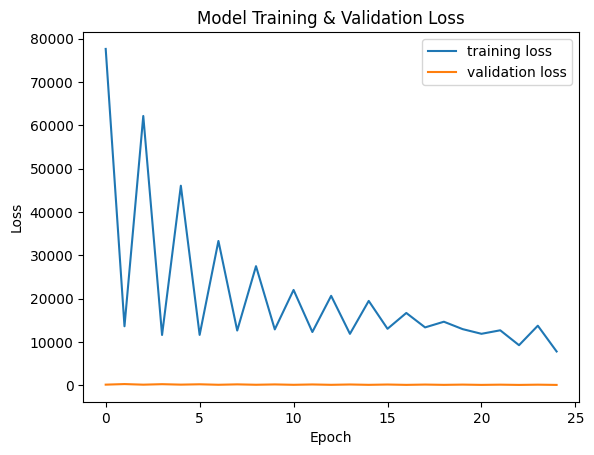

36/36 [==============================] - 1s 5ms/step


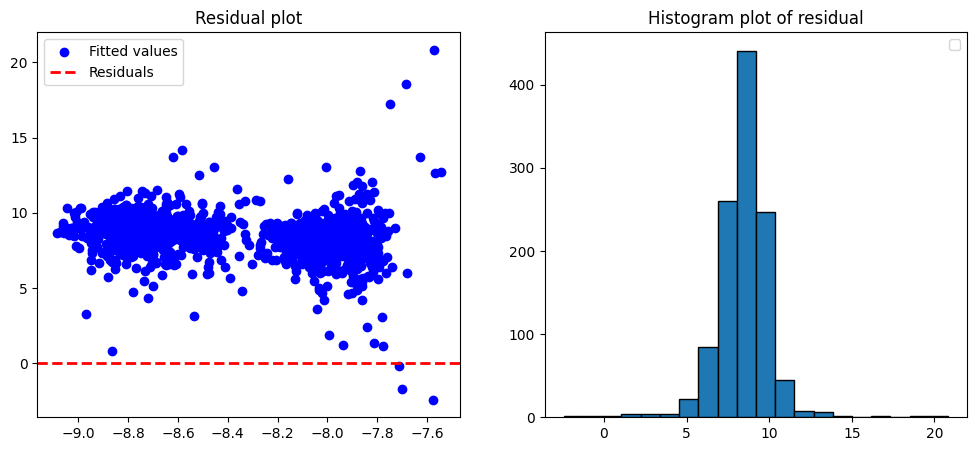

<Figure size 512x384 with 0 Axes>

  Training mean_absolute_percentage_error Loss    Validation mean_absolute_percentage_error Loss    Training RMSE    Training MAE    Training MAPE    Validation RMSE    Validation MAE    Validation MAPE
----------------------------------------------  ------------------------------------------------  ---------------  --------------  ---------------  -----------------  ----------------  -----------------
                                       7807.88                                           87.7415           0.4677        0.454989          7807.88           0.373849          0.370859            87.7415


In [34]:
model_gru2 = Sequential()
model_gru2.add(GRU(50, activation='tanh',input_shape=(look_back, features.shape[1])))
model_gru2.add(Dense(1, activation='tanh'))

# Compile the model
model_gru2.compile(optimizer='adam', loss='mean_absolute_percentage_error', metrics=[RootMeanSquaredError(),MeanAbsoluteError(),MeanAbsolutePercentageError()])

# Train the model
gru2_stats, gru2_predictions= train(model=model_gru2,
                                    X_train=X_train,
                                    y_train=y_train,
                                    X_test=X_test,
                                    y_test=y_test,
                                    epochs=25,
                                    batch_size=32,
                                    shuffle=True,
                                    validation_split = 0.1)

### Huber

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 50)                12200     
                                                                 
 dense_14 (Dense)            (None, 1)                 51        
                                                                 
Total params: 12251 (47.86 KB)
Trainable params: 12251 (47.86 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/25
128/128 [==============================] - 5s 21ms/step - loss: 0.0050 - root_mean_squared_error: 0.1000 - mean_absolute_error: 0.0697 - mean_absolute_percentage_error: 66321.5391 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0495 - val_mean_absolute_error: 0.0370 - val_mean_absolute_percentage_error: 8.7472
Epoch 2/25
128/128 [==============================] - 2s 17ms/step - loss: 0.0022

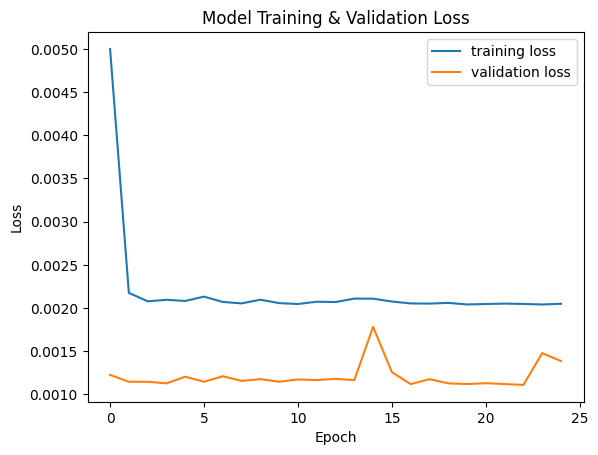

36/36 [==============================] - 1s 5ms/step


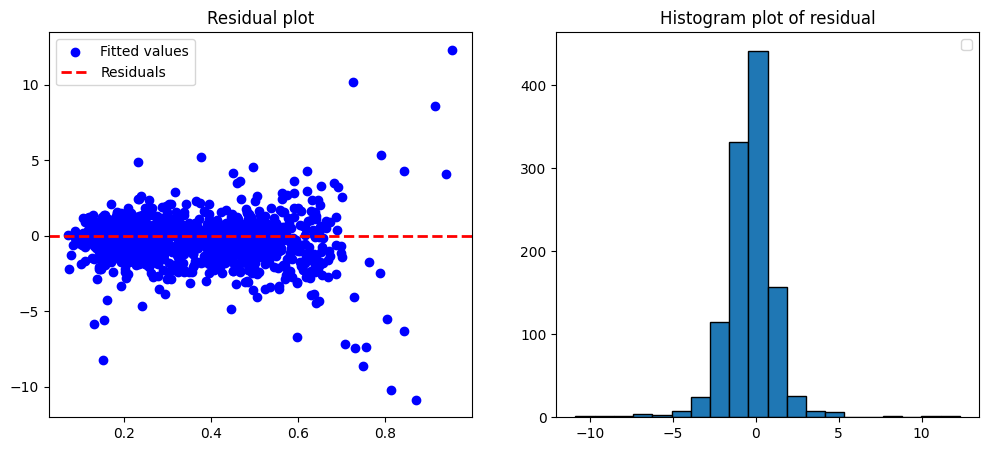

<Figure size 512x384 with 0 Axes>

  Training <keras.src.losses.Huber object at 0x780e658428c0> Loss    Validation <keras.src.losses.Huber object at 0x780e658428c0> Loss    Training RMSE    Training MAE    Training MAPE    Validation RMSE    Validation MAE    Validation MAPE
-----------------------------------------------------------------  -------------------------------------------------------------------  ---------------  --------------  ---------------  -----------------  ----------------  -----------------
                                                       0.00204922                                                            0.0013863         0.064019       0.0447651           106423          0.0526554         0.0407294            10.2751


In [35]:
model_gru3 = Sequential()
model_gru3.add(LSTM(50, activation='tanh',input_shape=(look_back, features  .shape[1])))
model_gru3.add(Dense(1, activation='tanh'))

# Compile the model
model_gru3.compile(optimizer='adam', loss=Huber(delta=1.0), metrics=[RootMeanSquaredError(),MeanAbsoluteError(),MeanAbsolutePercentageError()])

# Train the model
gru3_stats, gru3_predictions= train(model=model_gru3,
                                    X_train=X_train,
                                    y_train=y_train,
                                    X_test=X_test,
                                    y_test=y_test,
                                    epochs=25,
                                    batch_size=32,
                                    shuffle=True,
                                    validation_split = 0.1)

# GRU with dropout

### Mean Absolute Error

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 50)                9300      
                                                                 
 dropout_6 (Dropout)         (None, 50)                0         
                                                                 
 dense_15 (Dense)            (None, 1)                 51        
                                                                 
Total params: 9351 (36.53 KB)
Trainable params: 9351 (36.53 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/25
128/128 [==============================] - 5s 21ms/step - loss: 0.1071 - root_mean_squared_error: 0.1491 - mean_absolute_error: 0.1071 - mean_absolute_percentage_error: 99290.8906 - val_loss: 0.0593 - val_root_mean_squared_error: 0.0725 - val_mean_absolute_error: 0.0

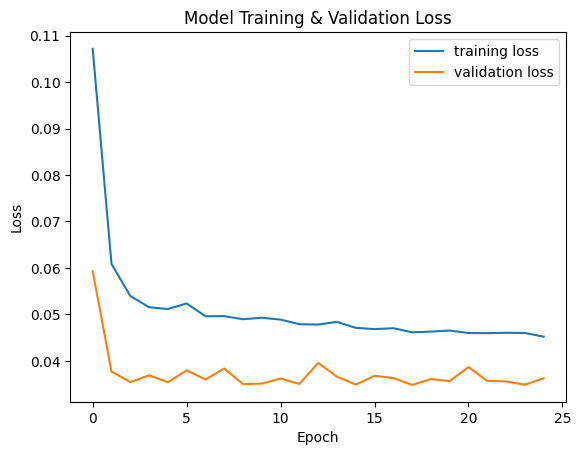

36/36 [==============================] - 1s 5ms/step


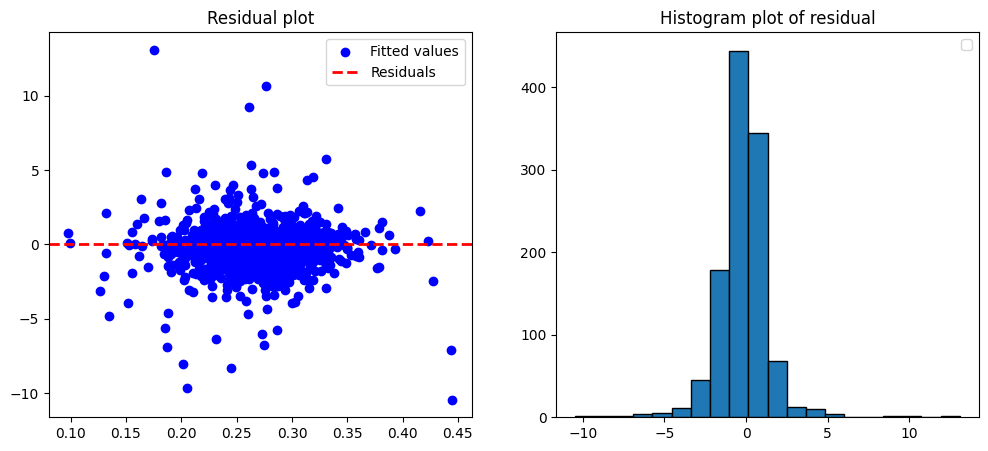

<Figure size 512x384 with 0 Axes>

  Training mean_absolute_error Loss    Validation mean_absolute_error Loss    Training RMSE    Training MAE    Training MAPE    Validation RMSE    Validation MAE    Validation MAPE
-----------------------------------  -------------------------------------  ---------------  --------------  ---------------  -----------------  ----------------  -----------------
                           0.045206                              0.0362619        0.0646083        0.045206           103805          0.0483762         0.0362619              8.977


In [36]:
# Create the model with MAE loss and Dropout
model_gru_with_dropout1 = Sequential()
model_gru_with_dropout1.add(GRU(50, activation='tanh', input_shape=(look_back, features.shape[1])))
model_gru_with_dropout1.add(Dropout(0.2))  # Add Dropout layer
model_gru_with_dropout1.add(Dense(1, activation='tanh'))

# Compile the model with MAE loss
model_gru_with_dropout1.compile(optimizer='adam', loss='mean_absolute_error', metrics=[RootMeanSquaredError(), MeanAbsoluteError(), MeanAbsolutePercentageError()])

# Train the model
gru_with_dropout_stats1, gru_with_dropout_predictions1 = train(model=model_gru_with_dropout1,
                                                          X_train=X_train,
                                                          y_train=y_train,
                                                          X_test=X_test,
                                                          y_test=y_test,
                                                          epochs=25,
                                                          batch_size=32,
                                                          shuffle=True,
                                                          validation_split=0.1)


### Mean Absolute Percentage Error

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_3 (GRU)                 (None, 50)                9300      
                                                                 
 dropout_7 (Dropout)         (None, 50)                0         
                                                                 
 dense_16 (Dense)            (None, 1)                 51        
                                                                 
Total params: 9351 (36.53 KB)
Trainable params: 9351 (36.53 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/25
128/128 [==============================] - 5s 21ms/step - loss: 69128.4609 - root_mean_squared_error: 0.2035 - mean_absolute_error: 0.1498 - mean_absolute_percentage_error: 69128.4609 - val_loss: 117.5075 - val_root_mean_squared_error: 0.4976 - val_mean_absolute_erro

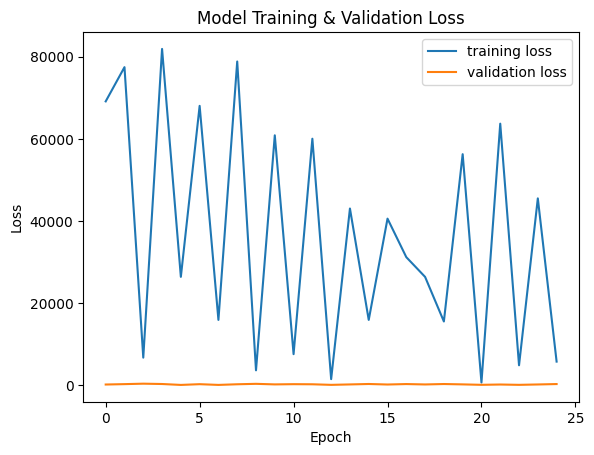

36/36 [==============================] - 1s 5ms/step


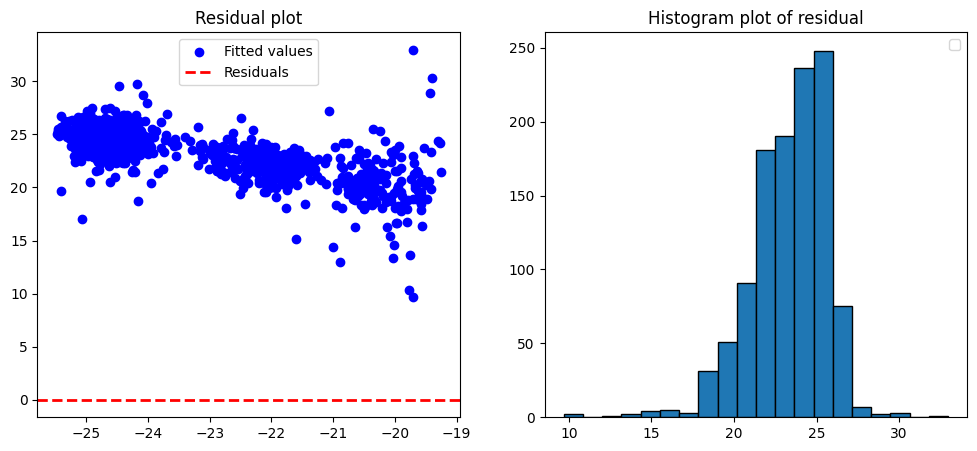

<Figure size 512x384 with 0 Axes>

  Training mean_absolute_percentage_error Loss    Validation mean_absolute_percentage_error Loss    Training RMSE    Training MAE    Training MAPE    Validation RMSE    Validation MAE    Validation MAPE
----------------------------------------------  ------------------------------------------------  ---------------  --------------  ---------------  -----------------  ----------------  -----------------
                                       5702.29                                             231.8         0.510345        0.477261          5702.29           0.972326          0.971044              231.8


In [37]:
# Create the model with MAPE loss and Dropout
model_gru_with_dropout2 = Sequential()
model_gru_with_dropout2.add(GRU(50, activation='tanh', input_shape=(look_back, features.shape[1])))
model_gru_with_dropout2.add(Dropout(0.2))  # Add Dropout layer
model_gru_with_dropout2.add(Dense(1, activation='tanh'))

# Compile the model with MAPE loss
model_gru_with_dropout2.compile(optimizer='adam', loss='mean_absolute_percentage_error', metrics=[RootMeanSquaredError(), MeanAbsoluteError(), MeanAbsolutePercentageError()])

# Train the model
gru_with_dropout_stats2, gru_with_dropout_predictions2 = train(model=model_gru_with_dropout2,
                                                            X_train=X_train,
                                                            y_train=y_train,
                                                            X_test=X_test,
                                                            y_test=y_test,
                                                            epochs=25,
                                                            batch_size=32,
                                                            shuffle=True,
                                                            validation_split=0.1)


### Huber

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_4 (GRU)                 (None, 50)                9300      
                                                                 
 dropout_8 (Dropout)         (None, 50)                0         
                                                                 
 dense_17 (Dense)            (None, 1)                 51        
                                                                 
Total params: 9351 (36.53 KB)
Trainable params: 9351 (36.53 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/25
128/128 [==============================] - 6s 21ms/step - loss: 0.0086 - root_mean_squared_error: 0.1313 - mean_absolute_error: 0.0966 - mean_absolute_percentage_error: 93328.4922 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0529 - val_mean_absolute_error: 0.0

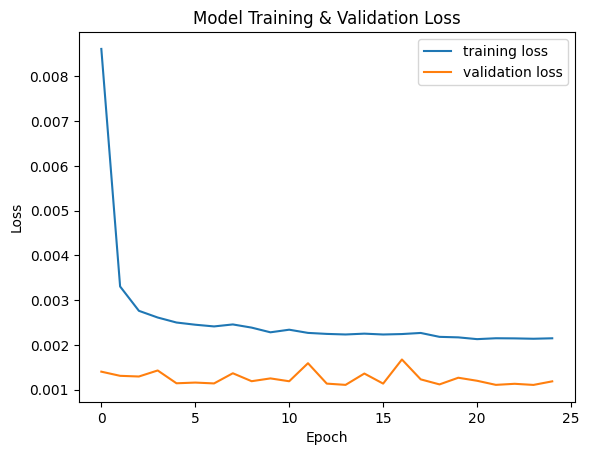

36/36 [==============================] - 1s 5ms/step


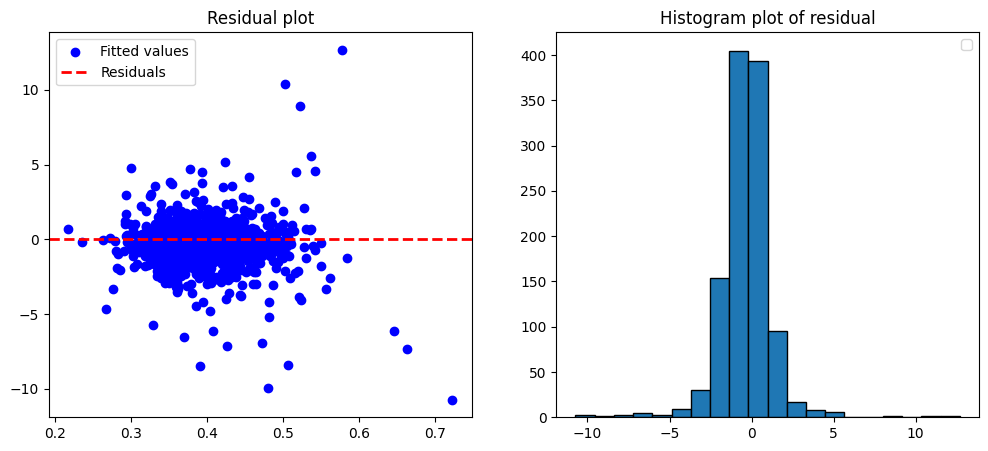

<Figure size 512x384 with 0 Axes>

  Training <keras.src.losses.Huber object at 0x780e62fc8dc0> Loss    Validation <keras.src.losses.Huber object at 0x780e62fc8dc0> Loss    Training RMSE    Training MAE    Training MAPE    Validation RMSE    Validation MAE    Validation MAPE
-----------------------------------------------------------------  -------------------------------------------------------------------  ---------------  --------------  ---------------  -----------------  ----------------  -----------------
                                                       0.00214783                                                           0.00118536        0.0655413       0.0463332           110228          0.0486901         0.0366703            9.10822


In [38]:
# Create the model with Huber loss and Dropout
model_gru_with_dropout3 = Sequential()
model_gru_with_dropout3.add(GRU(50, activation='tanh', input_shape=(look_back, features.shape[1])))
model_gru_with_dropout3.add(Dropout(0.2))  # Add Dropout layer
model_gru_with_dropout3.add(Dense(1, activation='tanh'))

# Compile the model with Huber loss
model_gru_with_dropout3.compile(optimizer='adam', loss=Huber(delta=1.0), metrics=[RootMeanSquaredError(), MeanAbsoluteError(), MeanAbsolutePercentageError()])

# Train the model
gru_with_dropout_stats3, gru_with_dropout_predictions3 = train(model=model_gru_with_dropout3,
                                                              X_train=X_train,
                                                              y_train=y_train,
                                                              X_test=X_test,
                                                              y_test=y_test,
                                                              epochs=25,
                                                              batch_size=32,
                                                              shuffle=True,
                                                              validation_split=0.1)
